In [2]:
import pandas as pd
import numpy as np
import xarray as xr
import geopandas as gp
from unidecode import unidecode

%load_ext autoreload
%autoreload 2

### 1. Read ERA5

The [ERA5-Land monthly averaged Reanalysis-data](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-land-monthly-means?tab=overview) has been manually downloaded from the copernicus climate change service.

In [3]:
# tmean and LAI 1968-2023
df1 = xr.open_dataset("data/ERA5/adaptor.mars.internal-1689317281.2867105-29547-5-0a3f055d-5520-4dc7-b544-9d9307e82d48.grib", filter_by_keys={'stepType': 'avgid'}).to_dataframe().reset_index().dropna().reset_index(drop=True)
# rain 1968 - 2001
df2 = xr.open_dataset("data/ERA5/adaptor.mars.internal-1689317281.2867105-29547-5-0a3f055d-5520-4dc7-b544-9d9307e82d48.grib", filter_by_keys={'stepType': 'avgas'}).to_dataframe().reset_index().dropna().reset_index(drop=True)
# rain 2002-2023
df3 = xr.open_dataset("data/ERA5/adaptor.mars.internal-1689317281.2867105-29547-5-0a3f055d-5520-4dc7-b544-9d9307e82d48.grib", filter_by_keys={'stepType': 'avgad'}).to_dataframe().reset_index().dropna().reset_index(drop=True)

rain = pd.concat([df2, df3], ignore_index=True).dropna().reset_index(drop=True)
era = df1.merge(rain, on=["time", "latitude", "longitude", "number", "step", "surface", "valid_time"])

In [4]:
# Kelvin to Celsius
era["t2m"] = era["t2m"].apply(lambda x: x - 273.15)
# time to datetime
era["time"] = pd.to_datetime(era["time"])
era["valid_time"] = pd.to_datetime(era["valid_time"])


era = (era
       .sort_values(by=["time", "latitude", "longitude"])
       .loc[:, ["time", "latitude", "longitude", "t2m", "tp"]]
       .rename(columns={"latitude":"lat", "longitude":"lon", "t2m":"tmean", "tp":"rain"})
       .reset_index(drop=True))

era["month"] = era["time"].dt.month
era["year"] = era["time"].dt.year
era = era.loc[era["month"].between(8,11) & (era["year"] >= 1993)].reset_index(drop=True)
era = era[["time", "lat", "lon", "rain", "tmean", "month", "year"]]
era = gp.GeoDataFrame(era, geometry=gp.points_from_xy(era["lon"], era["lat"], crs="EPSG:4326"))

era.head()

,time,lat,lon,rain,tmean,month,year,geometry
0,1993-08-01,-42.0,-69.0,0.000709,0.844141,8,1993,POINT (-69.00000 -42.00000)
1,1993-08-01,-42.0,-68.9,0.000661,0.514063,8,1993,POINT (-68.90000 -42.00000)
2,1993-08-01,-42.0,-68.8,0.000614,0.096094,8,1993,POINT (-68.80000 -42.00000)
3,1993-08-01,-42.0,-68.7,0.000561,0.221094,8,1993,POINT (-68.70000 -42.00000)
4,1993-08-01,-42.0,-68.6,0.000506,0.611719,8,1993,POINT (-68.60000 -42.00000)


### 2. Read Shapefiles and filter with names from subnational wheat dataset

In [5]:
# read subnational wheat series and store unique region names
relevant_areas = pd.read_csv("data/crop/subnational_yield_with_trend.csv")["name"].unique()

# Read ADM2 shapefiles (municipality level) and filter by relevant states
gdf_adm2 = gp.read_file("data/shapefile/arg_admbnda_adm2_unhcr2017.shp")
gdf_adm2["ADM2_ES"] = gdf_adm2["ADM2_ES"].str.lower().apply(lambda x: unidecode(x))
gdf_adm2["ADM1_ES"] = gdf_adm2["ADM1_ES"].str.lower().apply(lambda x: unidecode(x))
gdf_adm2["name"] = gdf_adm2["ADM1_ES"] + " " + gdf_adm2["ADM2_ES"]

# filter areas 
gdf_adm2 = gdf_adm2.loc[gdf_adm2["name"].isin(relevant_areas), ["name", "geometry"]].reset_index(drop=True)
gdf_adm2.head()

,name,geometry
0,buenos aires tres arroyos,"POLYGON Z ((-60.16947 -38.17843 0.00000, -60.0..."
1,buenos aires general pinto,"POLYGON Z ((-61.98441 -34.51765 0.00000, -61.8..."
2,buenos aires general juan madariaga,"POLYGON Z ((-57.10996 -36.83308 0.00000, -57.1..."
3,buenos aires necochea,"POLYGON Z ((-59.17038 -37.70095 0.00000, -59.1..."
4,buenos aires pergamino,"POLYGON Z ((-60.81730 -33.54358 0.00000, -60.8..."


#### Plot map of study region

<Axes: >

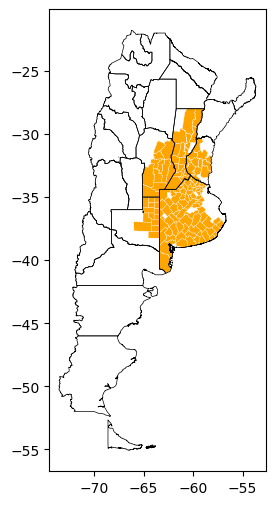

In [6]:
gdf_adm1 = gp.read_file("data/shapefile/arg_admbnda_adm1_unhcr2017.shp").to_crs("EPSG:4326")
base = gdf_adm2.plot(figsize=(6,6), color="orange", edgecolor="white", linewidth=.2)
gdf_adm1.plot(ax=base, color="#FF000000", edgecolor="black", linewidth=0.5)

### 3. Filter ERA by coordinates

In [7]:
# directly spatial join takes too much time
coordinates = gp.sjoin(era[["geometry", "lat", "lon"]].drop_duplicates(), gdf_adm2).reset_index(drop=True)[["name", "lat", "lon"]]
era = era.merge(coordinates[["lat", "lon", "name"]], on=["lat", "lon"], how="right")

# aggregate era across municipality (=name)
era = era.groupby(["name", "time", "year", "month"]).agg({"rain":"mean", "tmean":"mean"}).reset_index()
era.head()

,name,time,year,month,rain,tmean
0,buenos aires 25 de mayo,1993-08-01,1993,8,0.001157,10.575524
1,buenos aires 25 de mayo,1993-09-01,1993,9,0.003672,11.504344
2,buenos aires 25 de mayo,1993-10-01,1993,10,0.004624,15.942628
3,buenos aires 25 de mayo,1993-11-01,1993,11,0.005893,18.167580
4,buenos aires 25 de mayo,1994-08-01,1994,8,0.000567,10.210133


Check if all went well

<Axes: >

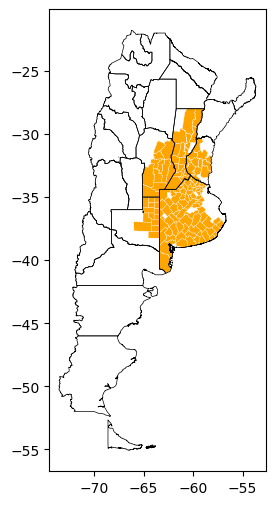

In [8]:
base = gdf_adm2.loc[gdf_adm2["name"].isin(era["name"].unique())].plot(figsize=(6,6), color="orange", edgecolor="white", linewidth=.2)
gdf_adm1.plot(ax=base, color="#FF000000", edgecolor="black", linewidth=0.5)

**Export preprocessed ERA**

In [9]:
era.to_csv("data/ERA5/era5_preprocessed.csv", index=False)

### 4. Restructure dataset

In [10]:
weather_features = era.pivot(index="year", columns=["name", "month"], values=["rain", "tmean"])

weather_features.columns = ["{}_{}_{}".format(s[0],s[1],s[2]) for s in weather_features.columns]

weather_features = weather_features.reset_index()
weather_features.head()

,year,rain_buenos aires 25 de mayo_8,rain_buenos aires 25 de mayo_9,rain_buenos aires 25 de mayo_10,rain_buenos aires 25 de mayo_11,rain_buenos aires 9 de julio_8,rain_buenos aires 9 de julio_9,rain_buenos aires 9 de julio_10,rain_buenos aires 9 de julio_11,rain_buenos aires adolfo alsina_8,...,tmean_santa fe san lorenzo_10,tmean_santa fe san lorenzo_11,tmean_santa fe san martin_8,tmean_santa fe san martin_9,tmean_santa fe san martin_10,tmean_santa fe san martin_11,tmean_santa fe vera_8,tmean_santa fe vera_9,tmean_santa fe vera_10,tmean_santa fe vera_11
0,1993,0.001157,0.003672,0.004624,0.005893,0.001226,0.003883,0.004158,0.006154,0.000183,...,17.686621,19.747070,12.375508,13.869561,18.270352,20.244004,15.307207,16.723047,20.544873,21.863350
1,1994,0.000567,0.004834,0.002982,0.001956,0.001133,0.002992,0.002993,0.001888,0.001488,...,17.330029,21.368066,12.409824,16.644229,18.007529,21.269316,15.093574,19.528076,20.530674,22.216523
2,1995,0.000519,0.000535,0.002790,0.001777,0.000444,0.000537,0.002799,0.002493,0.000266,...,17.024316,21.444287,12.731533,16.618955,17.346777,22.001201,15.981396,18.648125,19.918408,25.476445
3,1996,0.003349,0.001618,0.003890,0.004558,0.002707,0.001404,0.003781,0.003973,0.001928,...,18.583643,21.834033,15.332109,14.714336,18.796045,22.390439,19.006445,17.608613,20.811484,23.387070
4,1997,0.002340,0.001301,0.005324,0.005031,0.001671,0.001263,0.005907,0.004336,0.000586,...,17.721826,20.458887,13.922822,16.177031,18.135732,20.880957,17.679248,19.520986,20.985488,23.198037


In [11]:
weather_features.to_csv("data/features/era_features.csv", index=False)